# Compute FWHM of PSTHs for 11 and 30Hz

Only PSTHs with a significance level below 0.05 are used

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree
import seaborn as sns
from functools import reduce
from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table 
tqdm_notebook.pandas()

%matplotlib widget

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
std_gaussian_kde = 0.04
window_size = 0.03
tmin = 0. # delay to compute FWHM after stimulus onset

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [5]:
output = pathlib.Path('output/stimulus-response-fwhm')
(output / 'data').mkdir(parents=True, exist_ok=True)
(output / 'figures').mkdir(parents=True, exist_ok=True)
(output / 'statistics').mkdir(parents=True, exist_ok=True)

In [6]:
colors = ['#d95f02','#e7298a']
labels = [
    '11 Hz', 
    '30 Hz'
]
queries = [
    'frequency==11 and stim_location=="ms"',
    'frequency==30 and stim_location=="ms"']

In [7]:
data, labels, colors, queries = load_data_frames(queries, labels, colors)

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [8]:
# use baseline==False and p_e_peak < 0.05
session_units_sig = data.query('p_e_peak == p_e_peak')

In [9]:
session_units_sig

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,bs_ctrl,ns_inhibited,ns_not_inhibited,gridcell,bs_not_gridcell,label,label_num,query,color,cell_type
13,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,False,False,False,True,30 Hz,1.0,"frequency==30 and stim_location==""ms""",#e7298a,bs_not_gridcell
14,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,True,False,True,False,30 Hz,1.0,"frequency==30 and stim_location==""ms""",#e7298a,gridcell
15,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,True,False,False,False,30 Hz,1.0,"frequency==30 and stim_location==""ms""",#e7298a,ns_inhibited
16,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,False,False,False,True,30 Hz,1.0,"frequency==30 and stim_location==""ms""",#e7298a,bs_not_gridcell
17,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,False,False,False,True,30 Hz,1.0,"frequency==30 and stim_location==""ms""",#e7298a,bs_not_gridcell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,False,False,False,True,11 Hz,0.0,"frequency==11 and stim_location==""ms""",#d95f02,bs_not_gridcell
1280,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,False,False,False,True,11 Hz,0.0,"frequency==11 and stim_location==""ms""",#d95f02,bs_not_gridcell
1281,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,False,False,False,True,11 Hz,0.0,"frequency==11 and stim_location==""ms""",#d95f02,bs_not_gridcell
1282,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,False,False,False,True,11 Hz,0.0,"frequency==11 and stim_location==""ms""",#d95f02,bs_not_gridcell


In [10]:
def compute_fwhm(psth, times, t_min=None):
    """
    Compute PSTH. The function handles a single peak or multiple peaks. In the latter case, the peak containing the max peak is used
    """
    times_accepted = times > tmin
    max_idx = np.argmax(psth[times_accepted])
    idxs_greater = np.where(psth[times_accepted] > 0.5 * np.ptp(psth[times_accepted]))[0]
    
    if np.all(np.diff(idxs_greater) == 1):
        fwhm = times[times_accepted][idxs_greater[-1]] - times[times_accepted][idxs_greater[0]]
    else:
        # deal with multiple peaks. when multiple peaks are found, the one containing max_idx is used
        diff_splits = np.where((np.diff(idxs_greater) == 1) == False)[0]
        idxs_list = []
        for i, ds in enumerate(diff_splits):
            if i == 0:
                idxs_list.append(idxs_greater[:ds+1])
            elif i < len(diff_splits):
                idxs_list.append(idxs_greater[diff_splits[i-1]+1:ds+1])
        idxs_list.append(idxs_greater[ds+1:])
        
        for idxs in idxs_list:
            if max_idx in idxs:
                fwhm = times[times_accepted][idxs[-1]] - times[times_accepted][idxs[0]]
        
    return fwhm, psth[times_accepted][max_idx]

In [11]:
times = np.arange(-0.005, window_size, 1e-4)
tmin = 0.005
psths = []
def process(row):
    action_id = row['action']
    channel_group = row['channel_group']
    unit_name = row['unit_name']
    name = f'{action_id}_{channel_group}_{unit_name}'
    spike_times = data_loader.spike_train(action_id, channel_group, unit_name)
    
    spike_times = np.array(spike_times)
    
    stim_times = data_loader.stim_times(action_id) 
    
    stim_times = np.array(stim_times)
    
    _, spikes, kernel, p_e, p_i = stimulus_response_latency(
        spike_times, stim_times, window_size, std_gaussian_kde)
    
    psths.append(kernel(times))
    fwhm, peak = compute_fwhm(kernel(times), times, tmin)
    return pd.Series({
        'fwhm': fwhm,
        'peak': peak
    })

In [12]:
session_units_sig = session_units_sig.merge(
    session_units_sig.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

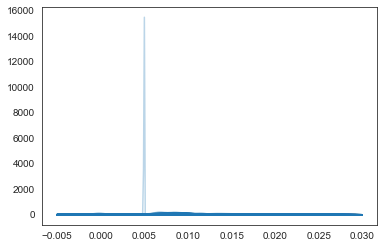

In [13]:
# Quality control
fig = plt.figure()
for psth in psths:
    plt.plot(times, psth, color='C0', alpha=0.3)

In [14]:
keys = [
    'fwhm',
    'peak'
]

results, labels = make_paired_tables(session_units_sig, keys, queries=queries, labels=labels, cell_types=['gridcell', 'ns_inhibited', 'ns_not_inhibited'])

## Plot FWHM grouped by stimulation frequency

In [15]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (1.7, 3),
    'figure.dpi': 150
})

In [16]:
def violinplot2(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmeans=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

 

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

 

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

[0.0, 0.6]
[0.0, 0.6]
[0.0, 0.6]


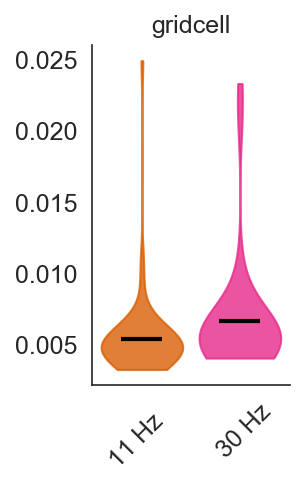

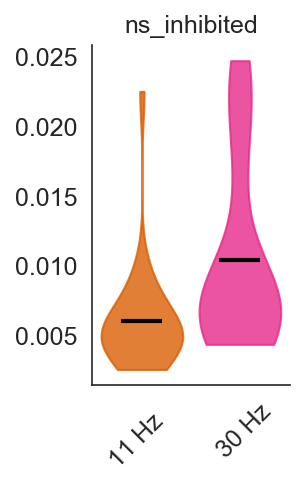

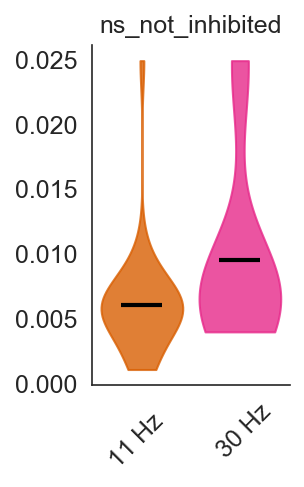

In [17]:
for cell_type, result, in results.items():
    fig = plt.figure()
    violinplot2(
        [result['fwhm']['11 Hz'].dropna().values, result['fwhm']['30 Hz'].dropna().values], 
        colors=colors,
        xticks=["11 Hz  ", "  30 Hz"],
    )
    plt.title(cell_type)
    figname = f'{cell_type}-stim-response-fwhm-11-30Hz'
    fig.savefig(
        output / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

[0.0, 0.6]
[0.0, 0.6]
[0.0, 0.6]


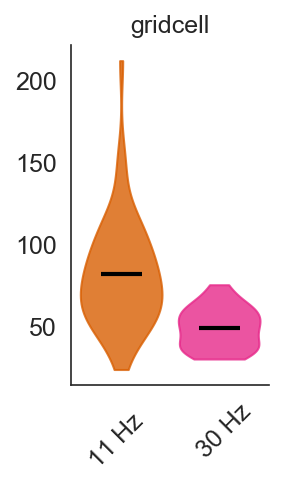

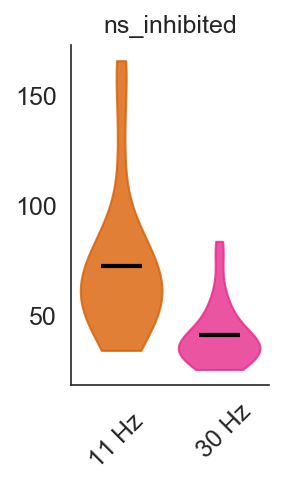

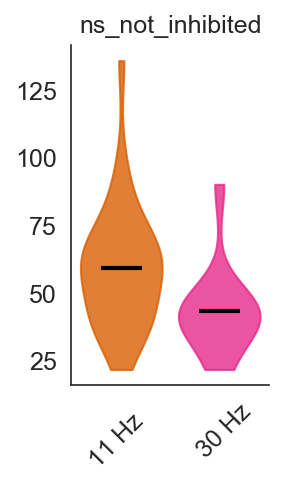

In [18]:
for cell_type, result, in results.items():
    fig = plt.figure()
    violinplot2(
        [result['peak']['11 Hz'].dropna().values, result['peak']['30 Hz'].dropna().values], 
        colors=colors,
        xticks=["11 Hz  ", "  30 Hz"],
    )
    plt.title(cell_type)
    figname = f'{cell_type}-stim-response-peak-11-30Hz'
    fig.savefig(
        output / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# stats

In [19]:
stats = {}
for cell_type, result in results.items():
    stats[cell_type], _ = make_statistics_table(result, labels)

In [20]:
stats['gridcell']

,Fwhm,Peak
11 Hz,5.0e-03 ± 2.5e-04 (58),9.0e+01 ± 3.9e+00 (58)
Normality 11 Hz,"1.0e+02, 5.8e-23","2.3e+01, 1.1e-05"
30 Hz,9.5e-03 ± 1.2e-03 (33),4.5e+01 ± 2.1e+00 (33)
Normality 30 Hz,"4.7e+01, 6.8e-11","2.5e+00, 2.8e-01"
LMM 11 Hz - 30 Hz,"1.2e-01 [-9.8e-04, 8.7e-03]","7.2e-04 [-6.9e+01, -1.8e+01]"


In [21]:
for cell_type, stat in stats.items():
    stat.to_latex(output / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output / "statistics" / f"statistics_{cell_type}.csv")

# Save to expipe

In [22]:
action = project.require_action("stimulus-response-fwhm")

In [23]:
action.modules['parameters'] = {
    'window_size': window_size,
    'std_gaussian_kde': std_gaussian_kde,
    'tmin': tmin
}

In [24]:
action.data['results'] = 'results.csv'
session_units_sig.to_csv(action.data_path('results'), index=False)

In [25]:
copy_tree(output, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/paired-statistics_ns_not_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/paired-statistics_gridcell.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/statistics_gridcell.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/paired-statistics_ns_inhibited.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/statistics_ns_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/statistics_bs.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/paired-statistics_bs_not_gridcell.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/statistics_gridcell.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-response-fwhm/data/statistics/paired-st

In [26]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-response-fwhm.ipynb")